# Preliminares

1. **Importar las librerías necesarias:**

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics



2. **Cargar los datos desde un archivo Excel:**



In [64]:
url = 'https://github.com/LordOnion88/MAD/raw/b6ef82a052a2c790788446e653919e3b029bd778/Series%20de%20Tiempo/Deterioro/base%20ajustada.xlsx'

df = pd.read_excel(url)
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%y')
df.set_index('Fecha', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2016-01-31 to 2024-10-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   valor   106 non-null    float64
 1   PIB     106 non-null    float64
 2   IPC     106 non-null    float64
 3   SMMLV   106 non-null    float64
dtypes: float64(4)
memory usage: 4.1 KB




3. **Explorar los datos:**



In [65]:
print(df.head())
print(df.describe())

                   valor       PIB     IPC  SMMLV
Fecha                                            
2016-01-31  9.009609e+08  0.023750  0.0589  0.045
2016-02-29  9.314697e+08  0.023750  0.0589  0.045
2016-03-31  9.770731e+08  0.023750  0.0589  0.045
2016-04-30  1.031098e+09  0.022473  0.0589  0.045
2016-05-31  7.553645e+08  0.022473  0.0589  0.045
              valor         PIB         IPC       SMMLV
count  1.060000e+02  106.000000  106.000000  106.000000
mean   9.889677e+08    0.025165    0.040521    0.071664
std    1.043912e+09    0.044932    0.026950    0.033533
min    2.012596e+08   -0.085640    0.002500    0.035000
25%    5.249336e+08    0.012111    0.019775    0.059000
50%    7.251064e+08    0.020874    0.036800    0.060000
75%    1.091591e+09    0.032395    0.058900    0.070000
max    7.729563e+09    0.108012    0.126900    0.160000


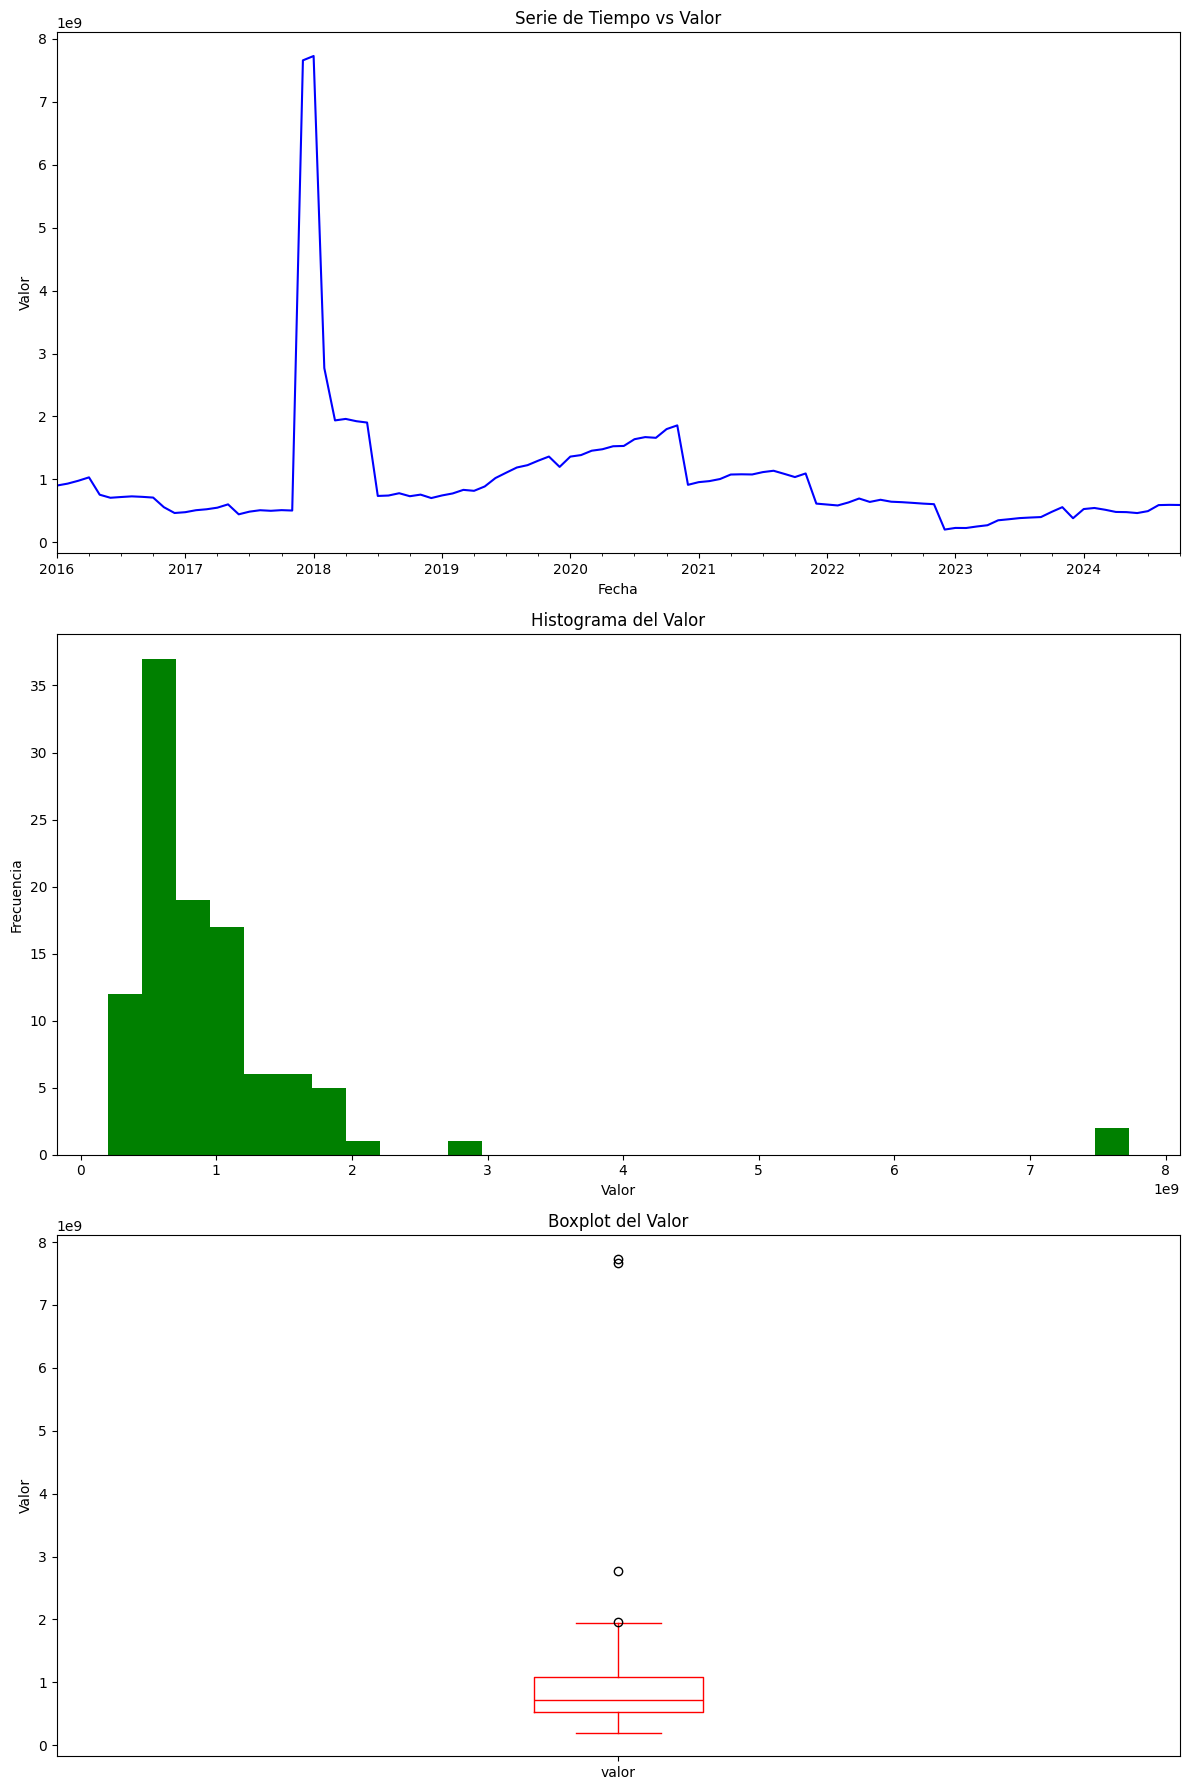

In [66]:
# Crear la figura y los ejes
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Graficar la serie de tiempo vs el valor
df['valor'].plot(ax=axes[0], title='Serie de Tiempo vs Valor', color='blue')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Valor')

# Graficar el histograma del valor
df['valor'].plot(kind='hist', bins=30, ax=axes[1], title='Histograma del Valor', color='green')
axes[1].set_xlabel('Valor')
axes[1].set_ylabel('Frecuencia')

# Graficar el boxplot del valor
df['valor'].plot(kind='box', ax=axes[2], title='Boxplot del Valor', color='red')
axes[2].set_ylabel('Valor')

# Mostrar los gráficos
plt.tight_layout()
plt.show()



4. **Visualizar las relaciones entre las variables:**



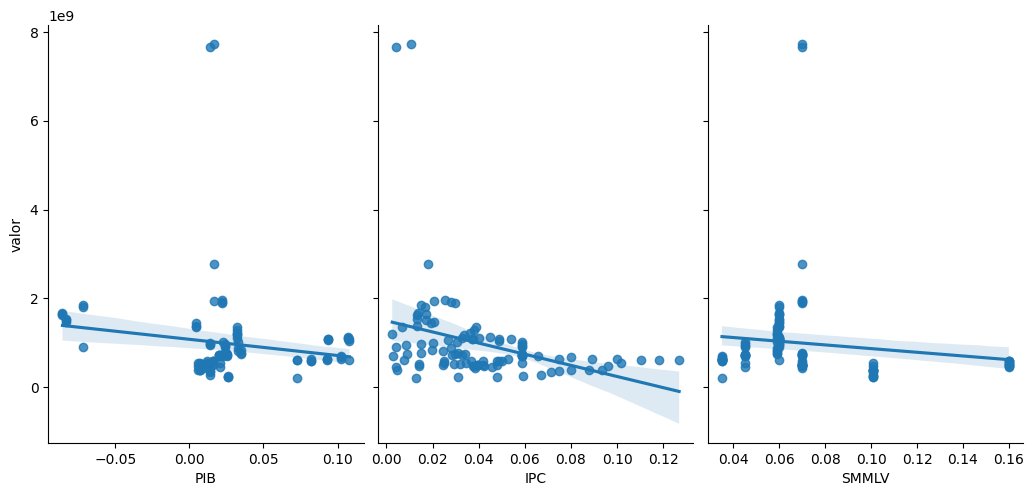

In [67]:
sns.pairplot(df, x_vars=['PIB', 'IPC', 'SMMLV'], y_vars='valor', height=5, aspect=0.7, kind='reg')
plt.show()



5. **Calcular la correlación:**



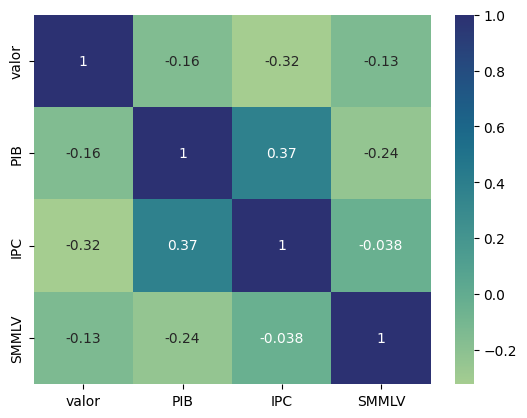

In [68]:
correlation_matrix = df[['valor', 'PIB', 'IPC', 'SMMLV']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='crest')
plt.show()

# Regresión multiple



6. **Dividir los datos en conjuntos de entrenamiento y prueba:**



In [69]:
X = df[['PIB', 'IPC', 'SMMLV']]
y = df['valor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)



7. **Ajustar un modelo de regresión lineal múltiple:**



In [70]:
X_train_const = sm.add_constant(X_train)  # Agregar una constante al modelo
model = sm.OLS(y_train, X_train_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  valor   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     3.177
Date:                Wed, 25 Dec 2024   Prob (F-statistic):             0.0285
Time:                        13:29:33   Log-Likelihood:                -1864.8
No. Observations:                  84   AIC:                             3738.
Df Residuals:                      80   BIC:                             3747.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.803e+08   9.12e+08      0.746      0.4



8. **Hacer predicciones en el conjunto de prueba:**



In [71]:
X_test_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_const)



9. **Visualizar la comparación entre los datos de entrenamiento, prueba y predicción:**



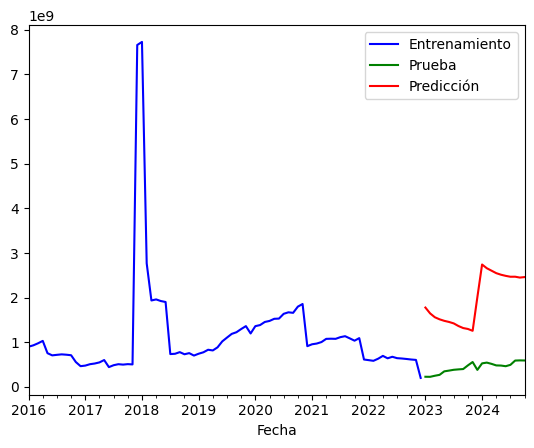

In [72]:
# Crear la figura y los ejes
fig, ax = plt.subplots()

# Graficar los datos de entrenamiento
y_train.plot(ax=ax, label='Entrenamiento', color='blue')

# Graficar los datos de prueba
y_test.plot(ax=ax, label='Prueba', color='green')

# Convertir y_pred a pandas.Series si es un numpy.ndarray
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Graficar las predicciones
y_pred_series.plot(ax=ax, label='Predicción', color='red')

# Añadir la leyenda
ax.legend()

# Mostrar la gráfica
plt.show()



10. **Interpretar los resultados:**

- **Coeficientes:** Indican la magnitud y dirección del efecto de cada variable independiente sobre la variable dependiente.
- **P-valores:** Indican si los coeficientes son significativamente diferentes de cero.
- **R-cuadrado:** Indica la proporción de la variabilidad en la variable dependiente explicada por las variables independientes.

11. **Conclusiones:**

- Si los coeficientes de PIB, IPC y SMMLV son significativos (p-valor < 0.05), entonces estas variables influyen en el valor.
- Si el R-cuadrado es alto, el modelo explica bien la variabilidad del valor.
- Analizar los gráficos de dispersión y la matriz de correlación para entender mejor las relaciones entre las variables.


# Prophet

Para realizar el análisis con Prophet, puedes seguir estos pasos:

1. **Importar las librerías necesarias:**





6. **Preparar los datos para Prophet:**

Prophet requiere que los datos tengan columnas específicas: `ds` para la fecha y `y` para el valor a predecir.



In [95]:
df_prophet = df.reset_index().rename(columns={'Fecha': 'ds', 'valor': 'y'})
df_prophet['cap'] = df_prophet['y'].max() * 0.8 
df_prophet

,ds,y,PIB,IPC,SMMLV,cap
0,2016-01-31,9.009609e+08,0.023750,0.0589,0.045,6.183650e+09
1,2016-02-29,9.314697e+08,0.023750,0.0589,0.045,6.183650e+09
2,2016-03-31,9.770731e+08,0.023750,0.0589,0.045,6.183650e+09
3,2016-04-30,1.031098e+09,0.022473,0.0589,0.045,6.183650e+09
4,2016-05-31,7.553645e+08,0.022473,0.0589,0.045,6.183650e+09
...,...,...,...,...,...,...
101,2024-06-30,4.636849e+08,0.014218,0.0457,0.160,6.183650e+09
102,2024-07-31,4.942029e+08,0.016221,0.0479,0.160,6.183650e+09
103,2024-08-31,5.901399e+08,0.016221,0.0478,0.160,6.183650e+09
104,2024-09-30,5.940624e+08,0.016221,0.0503,0.160,6.183650e+09




7. **Dividir los datos en conjuntos de entrenamiento y prueba:**



In [96]:
train_size = int(len(df_prophet) * 0.8)
train = df_prophet[:train_size]
test = df_prophet[train_size:]



8. **Ajustar el modelo de Prophet:**



In [97]:
model = Prophet(growth='logistic')
model.add_regressor('PIB')
model.add_regressor('IPC')
model.add_regressor('SMMLV')
model.fit(train)

13:38:30 - cmdstanpy - INFO - Chain [1] start processing


13:38:32 - cmdstanpy - INFO - Chain [1] done processing




9. **Hacer predicciones en el conjunto de prueba:**



In [98]:
future = model.make_future_dataframe(periods=22,freq = 'MS')
future['PIB'] = df['PIB'].values
future['IPC'] = df['IPC'].values
future['SMMLV'] = df['SMMLV'].values
future['cap'] = df_prophet['cap'].values

forecast = model.predict(future)
forecast.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,IPC,IPC_lower,IPC_upper,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
101,2024-06-01,1.520523e+09,6.183650e+09,3.869558e+09,6.413100e+09,1.520523e+09,1.520523e+09,6.481346e+07,6.481346e+07,6.481346e+07,...,3.732104e+09,3.732104e+09,3.732104e+09,-6.780102e+07,-6.780102e+07,-6.780102e+07,0.0,0.0,0.0,5.184826e+09
102,2024-07-01,1.528962e+09,6.183650e+09,3.564847e+09,6.293865e+09,1.528962e+09,1.528962e+09,8.078776e+07,8.078776e+07,8.078776e+07,...,3.739334e+09,3.739334e+09,3.739334e+09,-3.349502e+08,-3.349502e+08,-3.349502e+08,0.0,0.0,0.0,4.933346e+09
103,2024-08-01,1.537715e+09,6.183650e+09,3.916333e+09,6.681274e+09,1.537715e+09,1.537715e+09,8.006166e+07,8.006166e+07,8.006166e+07,...,3.738608e+09,3.738608e+09,3.738608e+09,6.128208e+07,6.128208e+07,6.128208e+07,0.0,0.0,0.0,5.337605e+09
104,2024-09-01,1.546501e+09,6.183650e+09,3.860037e+09,6.390954e+09,1.546501e+09,1.546501e+09,9.821427e+07,9.821427e+07,9.821427e+07,...,3.756761e+09,3.756761e+09,3.756761e+09,-1.031617e+08,-1.031617e+08,-1.031617e+08,0.0,0.0,0.0,5.200100e+09
105,2024-10-01,1.555036e+09,6.183650e+09,3.627618e+09,6.263497e+09,1.555036e+09,1.555036e+09,8.804881e+07,8.804881e+07,8.804881e+07,...,3.747559e+09,3.747559e+09,3.747559e+09,-3.461840e+08,-3.461840e+08,-3.461840e+08,0.0,0.0,0.0,4.956411e+09


/home/danielcardenas/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/danielcardenas/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


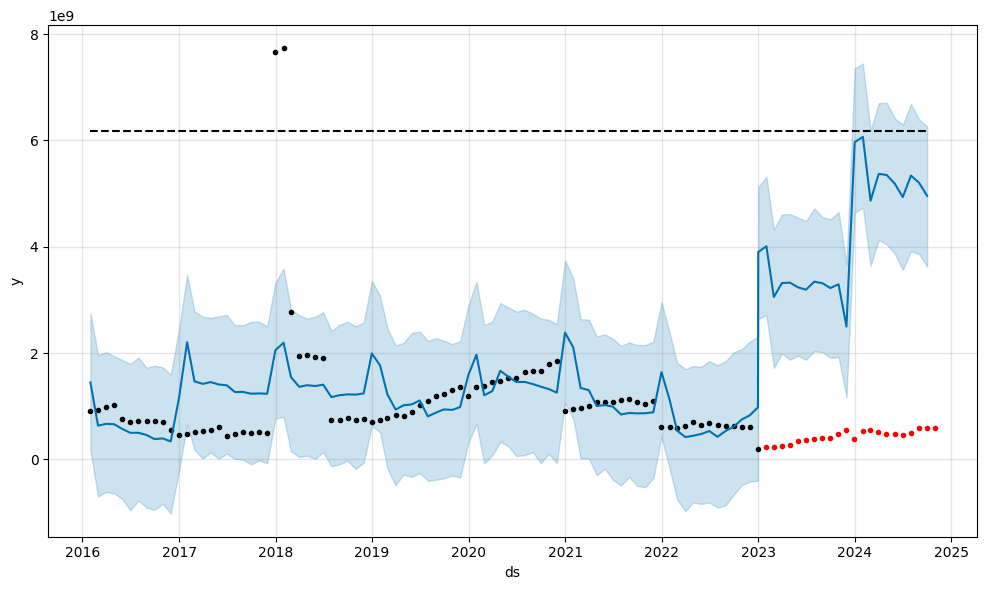

In [99]:
fig = model.plot(forecast)
ax= fig.gca()
ax.plot(test['ds'],test['y'],'r.')



10. **Visualizar la comparación entre los datos de entrenamiento, prueba y predicción:**



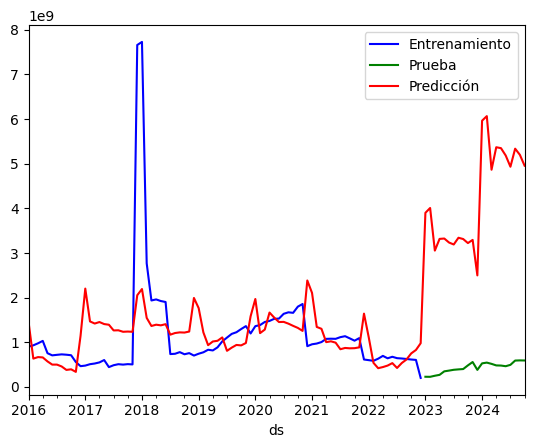

In [100]:
# Crear la figura y los ejes
fig, ax = plt.subplots()

# Graficar los datos de entrenamiento
train.set_index('ds')['y'].plot(ax=ax, label='Entrenamiento', color='blue')

# Graficar los datos de prueba
test.set_index('ds')['y'].plot(ax=ax, label='Prueba', color='green')

# Graficar las predicciones
forecast.set_index('ds')['yhat'].plot(ax=ax, label='Predicción', color='red')

# Añadir la leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [101]:
df_p_cv = cross_validation(model, initial='720 days',period='180 days',horizon='180 days')
df_p_cv.tail()

  0%|          | 0/10 [00:00<?, ?it/s]

13:38:35 - cmdstanpy - INFO - Chain [1] start processing
13:38:36 - cmdstanpy - INFO - Chain [1] done processing
13:38:36 - cmdstanpy - INFO - Chain [1] start processing
13:38:36 - cmdstanpy - INFO - Chain [1] done processing
13:38:37 - cmdstanpy - INFO - Chain [1] start processing
13:38:37 - cmdstanpy - INFO - Chain [1] done processing
13:38:37 - cmdstanpy - INFO - Chain [1] start processing
13:38:38 - cmdstanpy - INFO - Chain [1] done processing
13:38:38 - cmdstanpy - INFO - Chain [1] start processing
13:38:38 - cmdstanpy - INFO - Chain [1] done processing
13:38:39 - cmdstanpy - INFO - Chain [1] start processing
13:38:39 - cmdstanpy - INFO - Chain [1] done processing
13:38:39 - cmdstanpy - INFO - Chain [1] start processing
13:38:39 - cmdstanpy - INFO - Chain [1] done processing
13:38:40 - cmdstanpy - INFO - Chain [1] start processing
13:38:40 - cmdstanpy - INFO - Chain [1] done processing
13:38:40 - cmdstanpy - INFO - Chain [1] start processing
13:38:41 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
55,2022-08-31,-3.227453e+08,-1.682856e+09,1.067575e+09,6.365655e+08,2022-07-04
56,2022-09-30,-3.791628e+08,-1.791486e+09,1.047432e+09,6.256414e+08,2022-07-04
57,2022-10-31,-4.055413e+08,-1.750251e+09,9.126165e+08,6.136156e+08,2022-07-04
58,2022-11-30,-4.289081e+08,-1.816553e+09,9.778606e+08,6.047373e+08,2022-07-04
59,2022-12-31,1.242701e+09,-8.432780e+07,2.514046e+09,2.012596e+08,2022-07-04


In [102]:
df_per = performance_metrics(df_p_cv)
df_per.tail(6)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
49,166 days,2.740488e+19,5.234967e+09,4.135156e+09,3.755776,2.213763,1.395468,0.333333
50,170 days,2.936905e+19,5.419322e+09,4.560410e+09,4.125753,3.323694,1.283028,0.166667
51,171 days,1.522146e+19,3.901469e+09,3.035795e+09,3.328779,2.148431,0.959586,0.333333
52,175 days,6.121580e+18,2.474183e+09,2.018117e+09,1.927696,1.944149,0.857324,0.500000
53,176 days,5.960397e+18,2.441392e+09,1.870628e+09,1.791813,1.944149,0.776321,0.500000
54,180 days,5.545580e+18,2.354906e+09,1.729140e+09,2.391152,2.513998,0.869694,0.666667


/home/danielcardenas/.local/lib/python3.10/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/home/danielcardenas/.local/lib/python3.10/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


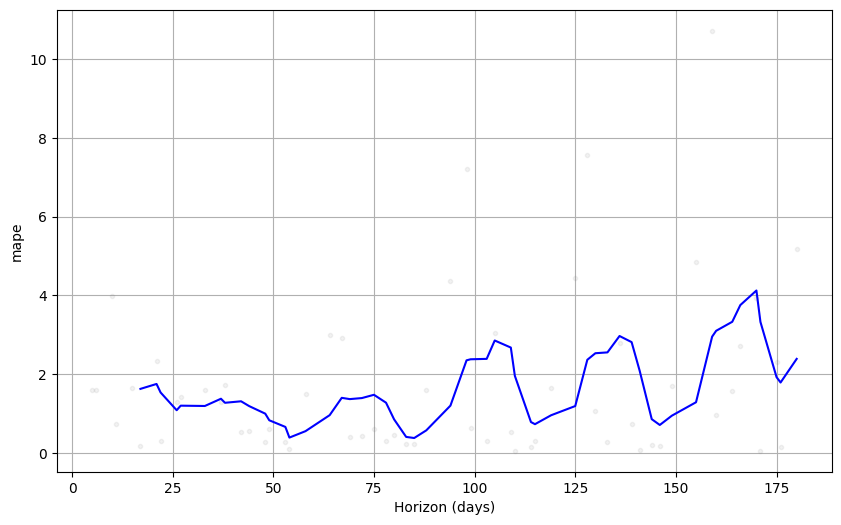

In [103]:
fig = plot_cross_validation_metric(df_p_cv, metric='mape')
plt.show()



11. **Interpretar los resultados:**

- **Coeficientes de regresores:** Prophet no proporciona coeficientes de regresores directamente, pero puedes evaluar la importancia de los regresores observando cómo afectan las predicciones.
- **Gráficos de componentes:** Prophet proporciona gráficos de componentes que muestran la tendencia, estacionalidad y efectos de los regresores.

12. **Conclusiones:**

- Analizar los gráficos de dispersión y la matriz de correlación para entender mejor las relaciones entre las variables.
- Evaluar la precisión de las predicciones comparando los valores reales con los valores predichos.

Siguiendo estos pasos, podrás aplicar un modelo de Prophet para validar si las variables PIB, IPC y SMMLV influyen en el valor y obtener conclusiones basadas en los resultados del análisis. Además, la gráfica te permitirá visualizar la comparación entre los datos de entrenamiento, prueba y predicción de manera correcta.